<a href="https://colab.research.google.com/github/PiotrDrajewicz/TensorFlow-Speech-Recognition-Challenge/blob/main/TensorFlow_Speech_Recognition_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os
root = '/content/gdrive/My Drive/colab/tm2020/Grupa_5/Projekt 2/data'  #ścieżka do katalogu roboczego na dysku google
os.chdir(root)

# Instalacja i import bibliotek

In [ ]:
import concurrent.futures
import pickle
import hashlib
import os, pickle
import re
import time
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from datetime import datetime
from packaging import version

# Zapięcie GPU i test

In [ ]:
#zamontowanie GPU
print("TensorFlow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version:  2.4.0
Num GPUs Available:  0


In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))


```
def which_set(filename, validation_percentage, testing_percentage)
```


Determines which data partition the file should belong to.
We want to keep files in the same training, validation, or testing sets even if new ones are added over time. 
This makes it less likely that testing samples will accidentally be reused in training when long runs are restarted for example. 
To keep this stability, a hash of the filename is taken and used to determine which set it should belong to. 
This determination only depends on the name and the set proportions, so it won't change as other files are added.
It's also useful to associate particular files as related (for example words spoken by the same person), so anything after 'nohash' in a filename is ignored for set determination. 
his ensures that 'bobby_nohash_0.wav' and 'bobby_nohash_1.wav' are always in the same set, for example.
```
Args: filename: File path of the data sample. 
validation_percentage: How much of the data set to use for validation. 
testing_percentage: How much of the data set to use for testing.
Returns: String, one of 'training', 'validation', or 'testing'. 
```
This looks a bit magical, but we need to decide whether this file should go into the training, testing, or validation sets, and we want to keep existing files in the same set even if more files are subsequently added. To do that, we need a stable way of deciding based on just the file name itself, so we do a hash of that and then use that to generate a probability value that we use to assign it.


The results of running this over the current set are included in this archive as validation_list.txt and testing_list.txt. These text files contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set.


In [ ]:
#wynik uruchomienia tej funkcji znajduje się w plikach tekstowych na dysku
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1 # ~134M
#MAX_NUM_WAVS_PER_CLASS = 2**3 - 1 # ~134M

def which_set(filename, validation_percentage, testing_percentage):
    base_name = os.path.basename(filename)
    hash_name = re.sub(r'nohash.*$', '', base_name)
    hash_name=hash_name.encode('utf-8')
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

In [ ]:
def load(path):
    path=root+path
    training=[]
    validation=[]
    testing=[]
    print(f'Rozpoczęto wczytywanie {path}')
    for i in os.listdir(path):
        set_name=which_set(path+i,10,10)
        if set_name=='training':
          fs, y = wavfile.read(path+i)
          y = y.astype('float32')
          training.append(y)
        elif set_name=='validation':
          fs, y = wavfile.read(path+i)
          y = y.astype('float32')
          validation.append(y)
        elif set_name=='testing':
          fs, y = wavfile.read(path+i)
          y = y.astype('float32')
          testing.append(y)
        else:
          print('ERROR: undefined set!')
    print(f'Wczytano zbiór {path}')
    return training,validation,testing

In [ ]:
paths = ['/train/audio/go/',
         '/train/audio/down/',
         '/train/audio/left/',
         '/train/audio/one/',
         '/train/audio/marvin/']
         #aby dodać nowy plik do wczytania dopisz kolejnego stringa po przecinku

*Lista dostępnych klas do wczytania*


>` !ls train/audio`


> ```
_background_noise_  dog    four   left	  off	 seven	 three	wow
bed		    down   go	  marvin  on	 sheila  tree	yes
bird		    eight  happy  nine	  one	 six	 two	zero
cat		    five   house  no	  right  stop	 up
```




In [ ]:
training=[]
validation=[]
testing=[]
start=time.perf_counter()
#with concurrent.futures.ThreadPoolExecutor() as executor:
    #results = executor.map(load,paths)
results=map(load,paths)
for result in results:
  training.append(result[0])
  validation.append(result[1])
  testing.append(result[2])
end = time.perf_counter()
print(f'Finished in {round(end-start,2)} seconds')

**UWAGA: gdzies tu prawdopodobnie jest bottleneck, to prawdopodobnie kwestia zapisu do trzech list
a nie jednej jak wczesniej. Sprawdzic czy trzeba zmienic ThreadPool na ProcessPool albo jakos inaczej zapisywac.

# Zapis do pickla

In [ ]:
#GODOLEONEMA - kolejnosc zapisanych slow w listach: 'GO' 'DOwn' 'LEft' 'ONE' 'MArvin'
outname=open('training',"wb")
pickle.dump(training,outname)
outname.close()
outname=open('validation',"wb")
pickle.dump(validation,outname)
outname.close()
outname=open('testing',"wb")
pickle.dump(testing,outname)
outname.close()

# Wczytanie pickla - TO URUCHAMIAĆ
**GODOLEONEMA**

In [ ]:
def pickle_out(picklename): 
    data = open(str(picklename), 'rb')
    name = pickle.load(data)
    return name

In [ ]:
#dodać tu multithreading
start=time.perf_counter()
train=pickle_out('training')
valid=pickle_out('validation')
test=pickle_out('testing')
end = time.perf_counter()
print(f'Finished in {round(end-start,2)} seconds')

Finished in 7.43 seconds


**Podsumowanie powyższego etapu**


*   Dostęp do nagrań: train[0][0] - pierwsze nagranie pierwszego słowa z zestawu treningowego

*  Można wygodnie wczytać pliki po prostu dodając ścieżkę w jednym miejscu
```
paths = ['/train/audio/nowa_sciezka/]
```
* Zbiory są dobierane z uwzględnieniem ich realnych rozmiarów, czyli jak na dysku google mamy niepełne zbiory niektórych klas to wczytywanie i tak zadziała i podzieli w dobrym stosunku
    > **UWAGA:** Zmiana stosunku podzialu zbioru odbywa sie w środku funkcji.
```
def load(path):
[...]
set_name=which_set(path+i,10,10)
```
Czyli obecnie zbior validacyjny 10% i testowy 10%

*   Zbiory dobierane są tylko na podstawie samych siebie - do działania programu nie potrzeba żadnego pliku z notatnika itp. Tym sposobem unikam szansy na błąd, np w złym zapisie nazwy plików.









# Do zrobienia:

**Zrobione**


---


*  14.01- Podać wczytane zbiory do obróbki spektrogramu - uzyskać log mel spektrogramy (najlepiej z pomocą tensorflow i zapiętym GPU)
  > **UWAGA:** po uruchomieniu komórki z wczytaniem pickli zbiory są już gotowe:
```
train #treningowy
valid #validacyjny
test #testowy
```
* 14.01- Poprawić kod sieci, żeby przyjmowała macierze log mel spektrogramów




**Do zrobienia**

---


*   Zapisać log mel spektrogramy do pickli (opcjonalne)

* 15.01- Pierwsze testy nowego trybu programu
* 15.01- Jeśli sieć działa, ogarnąć jakiegoś Profilera albo inne narzędzie do monitorowania treningu.
* Rozważyć augumentację danych
* Dobranie optymalnych parametrów (spektrogramu, sieci)
* Jeśli sieć działa, to zapisać do pickla cały zbiór (na PC)
* Przed zapisaniem całego zbioru zastanowić się czy da się ulepszyć load()









# Tworzenie log mel spektrogramów

In [ ]:
!pip install tensorflow_io==0.17.0
import tensorflow_io as tfio
import librosa
import librosa.display
import matplotlib.pyplot as plt
from numpy import array

In [ ]:
#funkcja licząca docelowo log mel spektrogramy dla całego danego zbioru
#testowane
'''fs,nfft,winlen,hop,nmels,fmin,fmax=16000,1024,1024,125,32,0,8000

def make_logmelspektr(input_list, output_list):
  Fs = 16000
  for i in range(len(input_list)):
    output_list.append([])
    for j in range(len(input_list[i])):
      #zeropadding do niepelneych nagran
      spektro = tfio.experimental.audio.spectrogram(input_list[i][j], nfft=1024, window=1024, stride=125)
      spektro = tf.cast(spektro, tf.float32)
      mel = tfio.experimental.audio.melscale(spektro,rate=fs,mels=nmels,fmin=fmin,fmax=fmax)
      logmel=tfio.experimental.audio.dbscale(mel,top_db=100)
      a = array(logmel)
      if a.shape != (128, 32): continue
      output_list[i].append((logmel,i))

In [ ]:
#padding
#testowane
'''incomplete=[]
final=[]
pad=np.zeros(16000)
for index,singleClass in enumerate(train):
  incomplete.append([])
  final.append([])
  for data in singleClass:
    if len(data)!=16000:
      incomplete[index].append(data)
      pad[:len(data)]=data
    else: 
        pad=data
    final[index].append(pad)

In [ ]:
#funkcja licząca docelowo log mel spektrogramy dla całego danego zbioru
#testowane
'''fs,nfft,winlen,hop,nmels,fmin,fmax=16000,1024,1024,125,32,0,8000

def make_logmelspektr2(input):
  print('Wczytuję...')
  Fs = 16000
  pad=np.zeros(Fs)
  output=[]
  for index,data in enumerate(input):
    if len(data)!=Fs:
      pad[:len(data)]=data
    else: 
        pad=data
    spektro = tfio.experimental.audio.spectrogram(pad, nfft=1024, window=1024, stride=125)
    spektro = tf.cast(spektro, tf.float32)
    mel = tfio.experimental.audio.melscale(spektro,rate=fs,mels=nmels,fmin=fmin,fmax=fmax)
    logmel=tfio.experimental.audio.dbscale(mel,top_db=100)
    a = array(logmel) #czemu konwertujemy tensor na array?
    if a.shape != (128, 32): continue
    output.append(logmel)
  print('Wczytano')
  return output

In [ ]:
#tworzenie listy log mel spektr dla zbioru treningowego
start=time.perf_counter()
lmstft=[]
for i in range(len(train)):
  lmstft.append([])
  for j in range(len(train[i])):
    lmstft[i].append(logmelstft(train[i][j]))
end = time.perf_counter()
print(f'Finished in {round(end-start,2)} seconds')

Finished in 238.74 seconds


In [ ]:
outname=open('lmstft_train',"wb")
pickle.dump(lmstft,outname)
outname.close()

In [ ]:
#tworzenie listy log mel spektr dla zbioru testowego
start=time.perf_counter()
lmstft_test=[]
for i in range(len(test)):
  lmstft_test.append([])
  for j in range(len(test[i])):
    lmstft_test[i].append(logmelstft(test[i][j]))
end = time.perf_counter()
print(f'Finished in {round(end-start,2)} seconds')

Finished in 31.99 seconds


In [ ]:
outname=open('lmstft_test',"wb")
pickle.dump(lmstft_test,outname)
outname.close()

In [ ]:
#tworzenie listy log mel spektr dla zbioru walidacyjnego
start=time.perf_counter()
lmstft_valid=[]
for i in range(len(valid)):
  lmstft_valid.append([])
  for j in range(len(valid[i])):
    lmstft_valid[i].append(logmelstft(valid[i][j]))
end = time.perf_counter()
print(f'Finished in {round(end-start,2)} seconds')

Finished in 28.87 seconds


In [ ]:
outname=open('lmstft_valid',"wb")
pickle.dump(lmstft_valid,outname)
outname.close()

# Wczytywanie LMSTFT z pickla

In [ ]:
train_lmstft=pickle_out('lmstft_train')
test_lmstft=pickle_out('lmstft_test')
valid_lmstft=pickle_out('lmstft_valid')

In [ ]:
#sprawdzenie rozmiarów
sum = 0
for i in range(5):
  #print(len(train_lmstft[i]))
  sum += len(valid_lmstft[i])
  print(sum)
#len(LogMelSpektr_train_list[2][0])

210
451
676
899
1087


Zamiana zbiorów treningowego i testowego na długie listy bez wyraźnego podziału na klasy w celu uzyskania odpowiedniego formatu dla sieci (do każdego nagrania przypisana jest cyfra od 0 do 4 określająca klase do której dane nagranie należy)

In [ ]:
#przekształcenie zbioru treningowego w długą liste bez wyraźnego podziały na klasy
oneD_train_list = sum(train_lmstft,[])
#przekształcenie zbioru testowego w długą liste bez wyraźnego podziały na klasy
oneD_test_list = sum(test_lmstft,[])
oneD_valid_list = sum(valid_lmstft,[])

# Rysowanie spektrogramów - obecnie niepotrzebne

1. Power spectrogram

In [ ]:
import matplotlib.pyplot as plt

def plot_2d(t,f,X,title, ylab):
    fig = plt.figure(figsize=(12, 3))
    im1 = plt.pcolormesh(t, f, X)
    plt.title(title)
    plt.xlabel("Time [sec]")
    plt.ylabel(ylab)
    fig.colorbar(im1)

In [ ]:
import librosa

#n_fft = 512     # Liczba prążków w STFT
#winlen = 320    # Długość okna
#winhop = 160     # Interwał pomiędzy oknami
#n_filt = 20     # Liczba filtrów melowych
#n_mfcc = 10     # Wyjściowa liczba wymiarów MFCC (cech)

fs = 16000
n_fft = 1024     # Liczba prążków w STFT
winlen = 1024    # Długość okna
winhop = 512     # Interwał pomiędzy oknami
n_filt = 128     # Liczba filtrów melowych
n_mfcc = 10     # Wyjściowa liczba wymiarów MFCC (cech)


#fs,nfft,winlen,hop,nmels,fmin,fmax=16000,1024,1024,512,32,0,8000

x = train[0][0]

#STFT
from scipy import signal, fftpack
f, t, X = signal.stft(x, fs, nperseg=winlen, noverlap=winlen-winhop, nfft=n_fft, window='hamming', padded=False, boundary=None)

PS = np.abs(X)**2
fbank =  librosa.filters.mel(fs, n_fft, n_mels = n_filt)

In [ ]:
#t = np.append(t, [0.992, 1.024])
#len(t)

In [ ]:
np.shape(PS.T)

(30, 513)

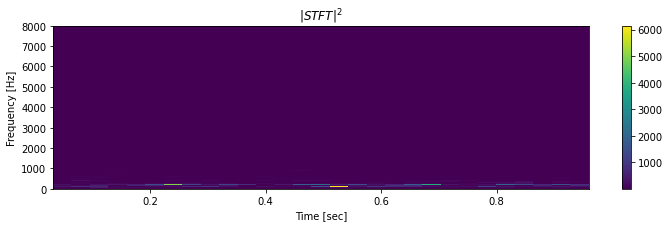

In [ ]:
plot_2d(t,f,PS,"$|STFT|^2$","Frequency [Hz]")

In [ ]:
print(PS.T)

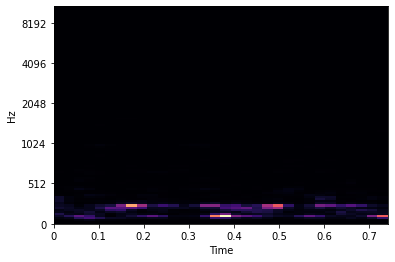

In [ ]:
import librosa.display

ps = librosa.feature.melspectrogram(y=train[0][0], sr=16000)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

2. Mel power spectrogram

In [ ]:
# pierwsze - numer klasy, drugie - numer nagrania
len(train[0][46])

960


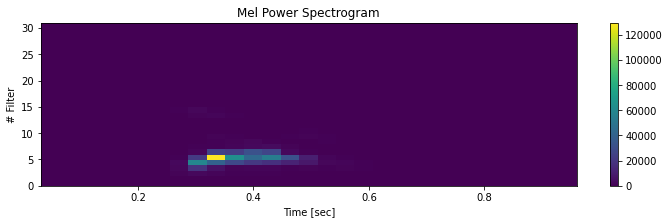

In [ ]:
# Mel Power Spectrogram
MPS = np.dot(fbank,PS)
plot_2d(t,np.arange(0,n_filt),MPS,"Mel Power Spectrogram","# Filter")
#print(MPS)
#print(t)
print(np.size(MPS))

3. Log mel power spectrogram

In [ ]:
# Logarithm
logMPS = np.log10(MPS)
plot_2d(t,np.arange(0,n_filt),logMPS,"Log(Mel Power Spectrogram)","# Filter")
#print(logMPS)
#np.size(logMPS)

# Parametryzacja danych do spektrogramów - obecnie niepotrzebne
testowane

In [ ]:
!pip install tensorflow_io==0.17.0

In [ ]:
import tensorflow_io as tfio

#ustawiam parametry potrzebne do policzenia poniższych funkcji (spektrogram, mel spektrogram, log - mel - spektrogram)
fs,nfft,winlen,hop,nmels,fmin,fmax=16000,1024,1024,512,32,0,8000
#parametry testowe 

In [ ]:
spectrogram_test=tfio.experimental.audio.spectrogram(
    train[0][0], nfft=1024, window=1024, stride=512)
#coś się policzyło - sprawdzić, czy to faktycznie spektrogram słowa 'go'
#spectrogram_test = tf.cast(spectrogram_test, tf.float32)
#mel-spektrogram nie chciał się policzyć bez linijki 5 - to chyba zwykła zmiana formatu na float32
print(spectrogram_test)

In [ ]:
t_new = t.T
print(np.shape(t))
#plot_2d(t_new,f,spectrogram_test,"$|STFT|^2$","Frequency [Hz]")

In [ ]:
mel_test=tfio.experimental.audio.melscale(spectrogram_test,rate=fs,mels=nmels,fmin=fmin,fmax=fmax)
#coś się policzyło - sprawdzić czy sensowne
print(mel_test)

In [ ]:
logmel_test=tfio.experimental.audio.dbscale(mel_test,top_db=100)
print(logmel_test)

In [ ]:
#test rozmiarów - zorientować się jaki rozmiar powinny mieć poprawnie policzone spektrogramy i porównać z wynikami
print(np.shape(spectrogram_test),
np.shape(mel_test),
np.shape(logmel_test))

# Sieć

In [ ]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''# Read Data
data = pd.read_csv('code/UrbanSound8K/metadata/UrbanSound8K.csv')
data.head(5)

In [ ]:
'''data.shape

In [ ]:
'''# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

In [ ]:
'''# Iterate over all samples in valid. For every sample, construct the (128,128) spectrogram
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [ ]:
'''D = [] # Dataset

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path, duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    D.append( (ps, row.classID) )

In [ ]:
'''print("Number of samples: ", len(D))

In [ ]:
train_made = oneD_train_list
test_made = oneD_test_list
valid_made=oneD_valid_list

# x to macierze spektrogramów, a y to cyfry określające do której klasy należy każde nagranie
X_train, y_train = zip(train_made[0])
X_test, y_test = zip(test_made[0])
X_valid, y_valid =zip(valid_made[0])

# Zmiana rozmiarów, żeby pasowało do sieci
X_train = np.array([tf.reshape(X_train, (128, 32, 1) ) for x in X_train])
X_test = np.array([tf.reshape(X_test, (128, 32, 1) ) for x in X_test])
X_valid = np.array([tf.reshape(X_test, (128, 32, 1) ) for x in X_valid])
# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 5))
y_test = np.array(keras.utils.to_categorical(y_test, 5))
y_valid = np.array(keras.utils.to_categorical(y_valid, 5))

In [ ]:
model = Sequential()
input_shape=(128, 32, 1) #input sieci musi byc taki sam jak wymiar macierzy czyli 128x128 jest ok o ile jest nmels=128

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(6)) #dense= 3+ 1 (3 komendy= go, down, left oraz 1 unknown=one, marvin)
model.add(Activation('softmax'))

In [ ]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])